# Attention-based GRN Inference on Fine-tuned Model

Here we use the fine-tuned blood model on the Adamson perturbation dataset as an
example of the cell-state specific GRN inference via attention weights. scGPT
outputs attention weights on the individual cell level, which can be further
aggregated by cell states. In this particular example, we compare the most
influenced genes between a transcription factor repression condition (perturbed)
and the control. However, this attention-based GRN inference is not restricted
to perturbation-based discoveries. It can also be used to compare between cell
states in general, such as healthy v.s. diseased, undifferentiated v.s.
differentiated, as a broader application.

Users may perform scGPT's attention-based GRN inference in the following steps:

     1. Load fine-tuned scGPT model and data

     2. Retrieve scGPT's attention weights by condition (i.e., cell states)

     3. Perform scGPT's rank-based most influenced gene selection

     4. Validate the most influenced gene list against existing databases


NOTE in advance: to run this tutorial notebook, you may need to download the
fine-tuned model from
[link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn)
and the list of targets of BHLHE40 from CHIP-Atlas for evaluation from
[link](https://drive.google.com/drive/folders/1nc1LywRHlzt4Z17McfXiqBWgoGbRNyc0).


In [5]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp
from gears import PertData, GEARS

from scipy.sparse import issparse
import scipy as sp
from einops import rearrange
from torch.nn.functional import softmax
from tqdm import tqdm
import pandas as pd

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")

import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.utils import set_seed
from scgpt.tokenizer import tokenize_and_pad_batch
from scgpt.preprocess import Preprocessor

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()


In [6]:
print(torch.cuda.is_available())

True


In [7]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

## Step 1: Load fine-tuned model and dataset


### 1.1 Load fine-tuned model

We are going to load a fine-tuned model for the gene interaction analysis on
Adamson dataset. The fine-tuned model can be downloaded via this
[link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn).
The dataset will be loaded in the next step 1.2.

To reproduce the provided fine-tuned model. Please followw the integration
fin-tuning pipeline to fine-tune the pre-trained blood model on the Adamson
perturbation dataset. Note that in the fine-tuning stage, we did not perform
highly vairable gene selection but trained on the 5000+ genes present in the
Adamson dataset. This is to provide flexbility in the inference stage to
investigate changes in attention maps across different perturbation conditions.


In [8]:
# Specify model path; here we load the scGPT blood model fine-tuned on adamson
model_dir = Path("../save/scGPT_human")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
    use_fast_transformer=True,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
Loading params transformer_encoder.layers.0.self_attn.Wqkv.bias with shape torch.Size([1536])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features

### 1.2 Load dataset of interest

The Adamson perturbation dataset is retrieved from the GEARS package with the
following code.


In [10]:
from anndata import AnnData

In [13]:
adata = AnnData((2**pd.read_csv('../../GroundTruth/remisdata/scRNA/chen_rna_filtered_log2.tsv', sep='\t'))-1).T

In [ ]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
adata.var

""
A2M
A2ML1-AS1
AAAS
AACS
AADAT
...
ZWINT
ZXDC
ZYG11B
ZZEF1


In [14]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='leiden_1.0', resolution=1.0)

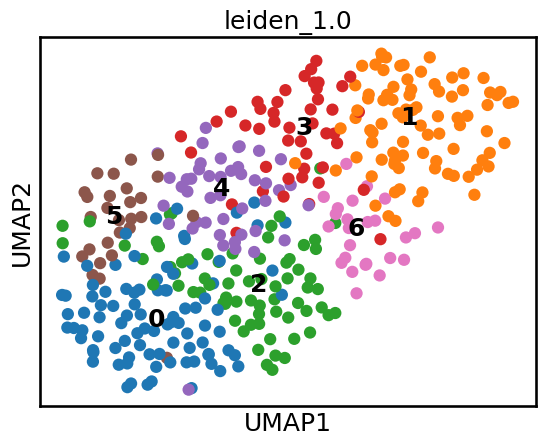

In [15]:
sc.pl.umap(adata, color=['leiden_1.0'], legend_loc='on data')

In [16]:
adata.var["id_in_vocab"] = [
    1 if gene in vocab else -1 for gene in adata.var.index
]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
adata = adata[:, adata.var["id_in_vocab"] >= 0]

In [ ]:
adata.shape

(385, 8127)

In the scGPT workflow, we compare each TF perturbation condition with control
one at a time. In each run, the data is subsetted to contain one TF and control
only. In this example, we use the TF BHLHE40.


We further pre-process the subsetted data following the scGPT pipeline.


In [17]:
data_is_raw=True

In [18]:
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=6,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="str_batch")

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


In [19]:
adata.shape

(385, 6585)

## Step 2: Retrieve scGPT's attention weights


### 2.1 Prepare model input


In [20]:
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var.index.tolist()
gene_ids = np.array(vocab(genes), dtype=int)

In [21]:
batch_size = 8
tokenized_all = tokenize_and_pad_batch(
    all_counts,
    gene_ids,
    max_len=len(genes) + 1,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)

In [22]:
all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])

### 2.1 Retrieve attention weights

Note that since the flash-attn package does not output attention scores, we
manually calculate q @ k.T to extract the attention weights. Users may specify
which layer to extract the attention weights from. In the manuscript, we used
the attention weights from the last (12th) layer.


In [23]:
torch.cuda.empty_cache()
dict_sum_condition = {}

In [24]:
# Use this argument to specify which layer to extract the attention weights from
# Default to 11, extraction from the last (12th) layer. Note that index starts from 0
num_attn_layers = 11

In [25]:
device

device(type='cuda')

In [28]:
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
    M = all_gene_ids.size(1)
    N = all_gene_ids.size(0)
    device = next(model.parameters()).device
    for i in tqdm(range(0, N, batch_size)):
        batch_size = all_gene_ids[i : i + batch_size].size(0)
        outputs = np.zeros((batch_size, M, M), dtype=np.float32)
        # Replicate the operations in model forward pass
        src_embs = model.encoder(
            torch.tensor(all_gene_ids[i : i + batch_size], dtype=torch.long).to(device)
        )
        val_embs = model.value_encoder(
            torch.tensor(all_values[i : i + batch_size], dtype=torch.float).to(device)
        )
        total_embs = src_embs + val_embs
        # total_embs = model.layer(total_embs.permute(0, 2, 1)).permute(0, 2, 1)
        # Send total_embs to attention layers for attention operations
        # Retrieve the output from second to last layer
        for layer in model.transformer_encoder.layers[:num_attn_layers]:
            total_embs = layer(
                total_embs,
                src_key_padding_mask=src_key_padding_mask[i : i + batch_size].to(
                    device
                ),
            )
        # Send total_embs to the last layer in flash-attn
        # https://github.com/HazyResearch/flash-attention/blob/1b18f1b7a133c20904c096b8b222a0916e1b3d37/flash_attn/flash_attention.py#L90
        qkv = model.transformer_encoder.layers[num_attn_layers].self_attn.Wqkv(
            total_embs
        )
        # Retrieve q, k, and v from flast-attn wrapper
        qkv = rearrange(qkv, "b s (three h d) -> b s three h d", three=3, h=8)
        q = qkv[:, :, 0, :, :]
        k = qkv[:, :, 1, :, :]
        v = qkv[:, :, 2, :, :]
        # https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a
        # q = [batch, gene, n_heads, n_hid]
        # k = [batch, gene, n_heads, n_hid]
        # attn_scores = [batch, n_heads, gene, gene]
        attn_scores = q.permute(0, 2, 1, 3) @ k.permute(0, 2, 3, 1)
        # apply softmax to get attention weights
        attn_scores = softmax(attn_scores, dim=-1)
        if i == 0:
            sm_attn_scores = attn_scores.sum(0).detach().cpu().numpy()
        else:
            # take the sum
            sm_attn_scores += attn_scores.sum(0).detach().cpu().numpy()

100%|██████████| 49/49 [01:04<00:00,  1.32s/it]


### trying with softmax

In [29]:
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [30]:
sm_attn_scores_h0 = pd.DataFrame(data=sm_attn_scores[0], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h0[(sm_attn_scores_h0>2).sum(0)>500].index

Index(['AC074363.1', 'ACTN1', 'AKAP12', 'ANKRD11', 'ANOS2P', 'APP', 'ARHGEF10',
       'ATP2A2', 'ATXN7L1', 'BCAT1', 'CACNA2D1', 'CERS6', 'COL18A1', 'COL4A1',
       'COL4A2', 'CSPP1', 'DDHD1', 'DPYSL3', 'EIF4G3', 'ESRG', 'FGFBP3',
       'FOXN3', 'GRID2', 'HNRNPU', 'HTR7', 'IGF2R', 'ITPR3', 'JMJD1C',
       'KIAA0825', 'LRP1', 'LRRTM4', 'MACF1', 'MFGE8', 'MIPOL1', 'MSH6',
       'NLGN4X', 'NLGN4Y', 'NPTN', 'PAK1', 'PLXDC2', 'PRKG1', 'PRKX', 'PRRC2B',
       'PTPRD', 'PTPRG', 'PTPRZ1', 'RASAL2', 'RIMS2', 'RP11-415G4.1',
       'RP11-624M8.1', 'SPARC', 'SPATS2L', 'TPM1', 'TRIO', 'VCAN', 'ZDHHC22'],
      dtype='object')

In [31]:
sm_attn_scores_h1 = pd.DataFrame(data=sm_attn_scores[1], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h1[(sm_attn_scores_h1>2).sum(0)>500].index

Index(['ARHGAP1', 'ATP1A2', 'B3GALT5-AS1', 'CDHR1', 'CNKSR2', 'COL14A1',
       'CYB5R2', 'DCBLD2', 'DSG2', 'EPHA1', 'EPHA6', 'ERBB2', 'ESRG', 'EXTL3',
       'FAM160A1', 'FAM171A1', 'FGFBP3', 'GFPT2', 'GNG12', 'GPR143', 'GPR173',
       'GRTP1', 'HEPH', 'IGSF1', 'ITGA7', 'ITPR3', 'JAG1', 'L1TD1', 'LPAR3',
       'LRCH3', 'MEGF10', 'MID1', 'MOV10', 'NELL2', 'NSUN7', 'PHLDB1',
       'PTPN13', 'RHBDF1', 'ROBO1', 'SLC25A21', 'SLC2A13', 'SLC2A3', 'SLC6A15',
       'SLC6A6', 'SLC7A2', 'SNTG2', 'TBC1D16', 'TRDN', 'TTC39C', 'UNC5D',
       'WWC1', 'ZNRF3'],
      dtype='object')

In [32]:
sm_attn_scores_h2 = pd.DataFrame(data=sm_attn_scores[2], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h2[(sm_attn_scores_h2>2).sum(0)>500].index

Index(['ABL1', 'AGPS', 'ANP32E', 'ATRN', 'CCDC77', 'CDC45', 'CDC7', 'CDK5RAP1',
       'CDT1', 'CENPQ', 'CHEK1', 'CKAP5', 'CNOT10', 'CSE1L', 'CSTF1', 'DNMT1',
       'E2F1', 'EXOSC9', 'FOXRED1', 'FUS', 'GLMN', 'GMNN', 'GNPTAB', 'GTF2H1',
       'HNRNPM', 'IPO9', 'JARID2', 'KDM2A', 'L3MBTL2', 'LDHA', 'LIG1',
       'MAP3K7', 'MCM10', 'MCM3', 'MCM5', 'MGME1', 'MSH2', 'MTHFD1', 'NCAPD3',
       'NCAPH', 'NCOR1', 'NIF3L1', 'NUP35', 'NUP50', 'NUP85', 'PANK2', 'PCNT',
       'POLE2', 'PPFIA1', 'PRKDC', 'PRRC2C', 'PSMD1', 'RBM25', 'RFC2', 'RFC4',
       'RHOT1', 'RIF1', 'RNF4', 'SEPHS1', 'SFXN2', 'SLC25A17', 'SLC7A3',
       'SPDL1', 'TCERG1', 'TIMELESS', 'TNPO3', 'TOE1', 'TUBA1C', 'UBE2D3',
       'UBE2K', 'UIMC1', 'UTP14C', 'ZNF714', 'ZNF789', 'ZWILCH'],
      dtype='object')

In [33]:
sm_attn_scores_h3 = pd.DataFrame(data=sm_attn_scores[3], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h3[(sm_attn_scores_h3>2).sum(0)>500].index

Index(['ACAP2', 'AKAP9', 'ANKRD11', 'ANKRD17', 'ARFGEF1', 'ASH1L', 'ATXN2',
       'BIRC6', 'BPTF', 'BRWD1',
       ...
       'USP34', 'WNK1', 'XPO5', 'ZFR', 'ZMYM2', 'ZNF195', 'ZNF292', 'ZNF43',
       'ZNF638', 'ZNF714'],
      dtype='object', length=105)

In [34]:
sm_attn_scores_h4 = pd.DataFrame(data=sm_attn_scores[4], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h4[(sm_attn_scores_h4>2).sum(0)>500].index

Index(['AC069277.2', 'AKAP9', 'ATRX', 'BPTF', 'BUB1B', 'CCDC150', 'CCDC18',
       'CCNF', 'CDC25C', 'CEP128', 'CIT', 'DDX17', 'DIAPH3', 'ECT2', 'FAM83D',
       'GEN1', 'GTSE1', 'HJURP', 'KIF14', 'KIF18B', 'KIF20B', 'KIF2C', 'MELK',
       'MIS18BP1', 'MT-CYB', 'NCAPG', 'NDC80', 'NEIL3', 'NLGN4Y', 'NUF2',
       'PIF1', 'PRRC2C', 'PSRC1', 'RFC3', 'RFWD3', 'RRM2', 'RTKN2', 'SASS6',
       'SMC4', 'SPC25', 'TACC3', 'TERF1', 'TICRR', 'TPR', 'TTK', 'ZNF730'],
      dtype='object')

In [35]:
sm_attn_scores_h5 = pd.DataFrame(data=sm_attn_scores[5], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h5[(sm_attn_scores_h5>2).sum(0)>500].index

Index(['ANKRD29', 'CASP6', 'CCDC80', 'CDHR1', 'CLYBL', 'CTSV', 'CYYR1',
       'DCBLD1', 'DCBLD2', 'EFEMP1', 'FAM189A2', 'FHDC1', 'FSTL1', 'GCNT2',
       'GNG12', 'GPR176', 'HS3ST4', 'ICA1', 'IQCK', 'MID1', 'OSBPL10',
       'PDGFRL', 'PDPN', 'PMP22', 'PRKCQ-AS1', 'PRSS23', 'RAB31', 'RASSF4',
       'SCN5A', 'SLC25A21', 'SLC6A15', 'SWAP70', 'SYT6', 'TMEM159', 'TMTC4',
       'UNC13B', 'WASF3', 'WWC1'],
      dtype='object')

In [36]:
sm_attn_scores_h6 = pd.DataFrame(data=sm_attn_scores[6], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h6[(sm_attn_scores_h6>2).sum(0)>500].index

Index(['ACACA', 'AK4', 'ANOS2P', 'ARL15', 'BDNF-AS', 'CACNA2D1', 'CBLB',
       'CPT1C', 'DAB1', 'DLGAP1', 'DNMT3B', 'DPYSL3', 'EME2', 'FER', 'GALNT7',
       'GJA1', 'GPC4', 'GRID2', 'HIP1', 'JMJD1C', 'KIAA0825', 'KIF1A',
       'L3MBTL3', 'MAP3K4', 'MDN1', 'MMP16', 'MTHFD1L', 'MTOR', 'MYO9B',
       'NFE2L3', 'NUP210', 'PHC1', 'PLS3', 'PLXDC2', 'POLR3G', 'PTPRD',
       'PTPRG', 'ROBO1', 'RRP12', 'SLC29A2', 'TRIM24', 'TRIM71', 'TXNDC16',
       'UGGT2', 'URB1', 'VLDLR-AS1', 'WDFY2', 'WDR59', 'ZDHHC22', 'ZNF121'],
      dtype='object')

In [37]:
sm_attn_scores_h7 = pd.DataFrame(data=sm_attn_scores[7], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h7[(sm_attn_scores_h7>2).sum(0)>500].index

Index(['AC004076.9', 'ANKRD27', 'ANO10', 'ATG14', 'ATG16L1', 'ATP6V0A2',
       'BBS2', 'BCKDHB', 'BTAF1', 'C16orf70', 'C1GALT1', 'CAMSAP1', 'CAPRIN2',
       'CCDC93', 'CDC16', 'CDS2', 'CEP70', 'CEP83', 'CERS5', 'CHFR', 'CHST12',
       'CNOT10', 'CROCC', 'CSPP1', 'DDHD2', 'DMTF1', 'EXT2', 'FER', 'FLVCR1',
       'GABBR1', 'GAN', 'GGA2', 'GPR107', 'GPR89A', 'GRIPAP1', 'HACL1',
       'HERC2P2', 'INO80D', 'INTS8', 'KDM2B', 'KIZ', 'LARS2', 'LMBR1',
       'LMBR1L', 'LONRF1', 'MADD', 'MAP3K7', 'MAPK9', 'MCM3AP', 'MDN1',
       'NAA16', 'NAPB', 'NR2C1', 'OPA1', 'ORC3', 'PIGG', 'PIGL', 'PLEKHA8',
       'POLR3A', 'PPP4R1', 'PRKAB2', 'PTBP2', 'PUDP', 'RARS2', 'RIPK1',
       'RP1-167A14.2', 'S100PBP', 'SENP2', 'SIN3B', 'SNX13', 'SPG7', 'SPIN3',
       'STX18', 'TBCD', 'TET1', 'TMEM184B', 'TRIM37', 'TRIT1', 'UGGT1',
       'USP20', 'USP45', 'WDR44', 'YEATS2', 'ZC4H2', 'ZDHHC17', 'ZNF33A',
       'ZNF532', 'ZNF84'],
      dtype='object')

'ATF3',
 'CBX8',
 'NANOG',
 'RXRA',
 'SAP30',

In [ ]:
- CTBP2 in h7
- POU5F1 in h1, h4
- SUZ12 in h2
- JUN, KDM5A in h4

In [39]:
(sm_attn_scores_h4.loc[:,[
 'CTBP2',
 'JUN',
 'KDM5A',
 'MYC',
 'POU5F1',
 'REST',
 'SUZ12']]>2).sum(0)

CTBP2      1
JUN       17
KDM5A      5
MYC        0
POU5F1     3
REST       0
SUZ12      0
dtype: int64

In [43]:
sm_attn_scores_h1[sm_attn_scores_h1['POU5F1']>1]['POU5F1']

AC009403.2    1.256775
AGTPBP1       1.369478
ASRGL1        1.177755
C1orf21       1.561926
C6orf132      1.468876
CDK14         1.522636
CHST9         2.264276
CORO2A        4.205293
EFCAB2        1.221865
EPHX2         5.611820
ITGA2         1.759518
PTPRG-AS1     1.035456
Name: POU5F1, dtype: float32

In [47]:
set(sm_attn_scores_h1.index) & set({'CDX2', 'FGFR2', 'HESX1', 'NANOG', 'OTX2', 'PHC1', 'POU5F1', 'REST', 'SOX2'})

{'FGFR2', 'HESX1', 'PHC1', 'POU5F1', 'REST'}

In [53]:
sm_attn_scores_h6

,<cls>,A2M,A2ML1-AS1,AAAS,AACS,AADAT,AAK1,AAMDC,AAR2,AARS2,...,ZSCAN29,ZSCAN30,ZSCAN9,ZSWIM6,ZSWIM7,ZWILCH,ZWINT,ZXDC,ZZEF1,ZZZ3
<cls>,5.469894e-24,3.603647e-11,2.041799e-07,7.020150e-10,0.708185,0.007651,0.000012,7.700687e-14,0.000047,0.000928,...,1.782746e-16,1.386043e-11,2.695617e-06,8.737299e-19,1.369459e-11,2.154669e-06,4.198771e-13,0.000532,1.311442e-23,3.497860e-07
A2M,4.798223e-12,4.946420e-08,2.742793e-04,1.758731e-05,0.172523,0.011252,0.000519,7.123806e-08,0.002022,0.029963,...,1.836345e-09,4.309542e-06,2.292635e-04,2.758255e-11,1.213514e-06,5.472377e-05,1.936797e-07,0.001536,1.278936e-13,3.405679e-05
A2ML1-AS1,1.109466e-16,1.566302e-07,2.817782e-06,4.867422e-07,0.297205,0.000087,0.000673,2.001106e-09,0.000185,0.008028,...,1.720960e-13,1.569618e-10,1.211341e-05,8.636718e-14,1.721278e-07,1.015880e-05,7.139113e-09,0.000342,2.404030e-19,4.924420e-06
AAAS,1.699819e-15,5.350672e-07,1.014307e-04,6.623388e-08,0.189294,0.000007,0.000407,1.054625e-08,0.001084,0.012341,...,2.457057e-13,3.045493e-11,3.902227e-06,3.686557e-16,2.531728e-06,4.185665e-06,5.649630e-07,0.000347,2.417834e-20,1.897555e-05
AACS,3.880906e-14,1.359513e-08,2.125757e-05,2.749306e-05,0.972692,0.000001,0.000513,1.551357e-09,0.000322,0.020745,...,1.046544e-11,3.298867e-08,9.372757e-07,2.325674e-11,5.508788e-06,1.670348e-07,2.821232e-07,0.005588,2.905312e-15,1.401923e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWILCH,1.252163e-16,1.036182e-05,2.422251e-06,8.783523e-08,0.835561,0.002058,0.000734,8.351669e-09,0.000540,0.005259,...,6.045074e-14,6.847463e-11,3.240232e-04,9.457303e-16,1.483636e-08,2.928368e-06,3.659824e-08,0.000459,1.035163e-20,4.871220e-06
ZWINT,9.594151e-18,2.974966e-06,1.135038e-05,1.574183e-07,0.649088,0.000388,0.000330,8.378746e-09,0.000187,0.008335,...,4.691893e-15,2.637299e-12,1.382981e-05,1.796030e-18,6.422682e-08,3.632369e-06,3.789042e-10,0.000094,4.157239e-23,7.158479e-07
ZXDC,1.541514e-17,2.670330e-08,1.817235e-06,1.763488e-08,0.669788,0.096134,0.000276,1.725254e-10,0.000635,0.004819,...,2.653458e-12,1.234087e-08,1.109618e-04,1.978908e-13,5.490104e-09,8.748338e-05,3.366627e-10,0.000789,7.575397e-18,3.557317e-06
ZZEF1,1.609583e-16,1.166739e-09,2.273059e-06,9.532414e-08,0.270431,0.012077,0.000442,2.672305e-10,0.000117,0.007739,...,1.038560e-09,3.187503e-07,1.691384e-04,1.067575e-10,4.216480e-09,2.749562e-05,6.876666e-10,0.038932,6.725706e-16,9.574518e-05


0       6350
1         30
2         20
5         10
3          7
        ... 
6008       1
1875       1
33         1
6519       1
38         1
Length: 132, dtype: int64


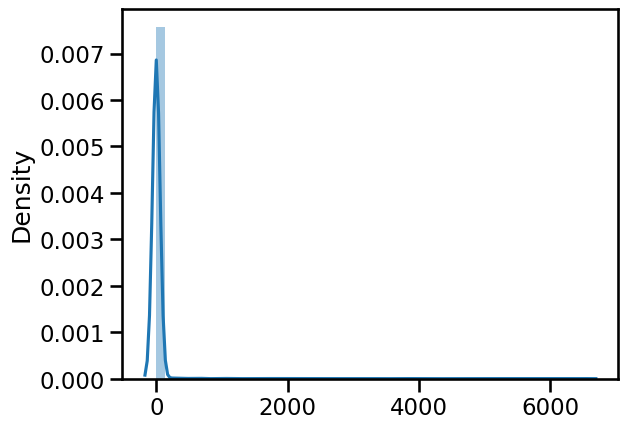

In [40]:
#(sm_attn_scores_h0>2).sum()
# plot distribution
import seaborn as sns

sns.distplot((sm_attn_scores_h0>2).sum())

print((sm_attn_scores_h0>2).sum().value_counts())

### trying with average cell expression

### is the attention changing a lot when  giving similar profiles?

### trying to find best attention head

### 2.2 Average rank-normed attention weights by condition

In the previous step, we retrieve the attention weights for all cells and keep
the running sum by condition (i.e., control, perturbed). We further calculate
the mean here by dividing the number of cells per condition to obtain a gene \*
gene attention matrix for each condition.


In [8]:
import pickle

In [53]:
# Save the dict_sum_condition dictionary into a pickle file
with open("dict_sum_condition.pkl", "wb") as f:
    pickle.dump(dict_sum_condition, f)

In [9]:
with open("dict_sum_condition.pkl", "rb") as f:
    dict_sum_condition = pickle.load(f)

In [10]:
dict_sum_condition["ctrl"][:, 0].min()

5702.0806

In [11]:
dict_sum_condition

{'ctrl': array([[13933.864 , 14750.036 ,  7468.2954, ..., 21075.678 , 15333.064 ,
         16293.599 ],
        [10553.35  , 12885.937 ,  8244.175 , ..., 12384.878 , 14053.346 ,
         10432.787 ],
        [12433.894 ,  8533.326 , 15626.939 , ...,  9253.183 ,  6305.4907,
         10466.165 ],
        ...,
        [11588.803 , 16553.75  , 11178.08  , ..., 18365.686 , 15135.463 ,
         13061.    ],
        [11135.912 , 18614.648 ,  9089.965 , ..., 15606.838 , 21313.943 ,
         15026.249 ],
        [12904.683 , 13994.017 , 10414.641 , ..., 16110.174 , 15675.613 ,
         15082.077 ]], dtype=float32),
 'BHLHE40+ctrl': array([[300.7011 , 294.17953, 155.30495, ..., 423.96136, 339.4864 ,
         319.47537],
        [219.44547, 259.5443 , 182.31548, ..., 218.70398, 255.34238,
         155.50034],
        [223.41988, 134.66891, 332.64105, ..., 201.34746, 137.39313,
         240.91937],
        ...,
        [240.07225, 360.40375, 259.83072, ..., 387.48706, 325.08456,
         270.49344

<Axes: >

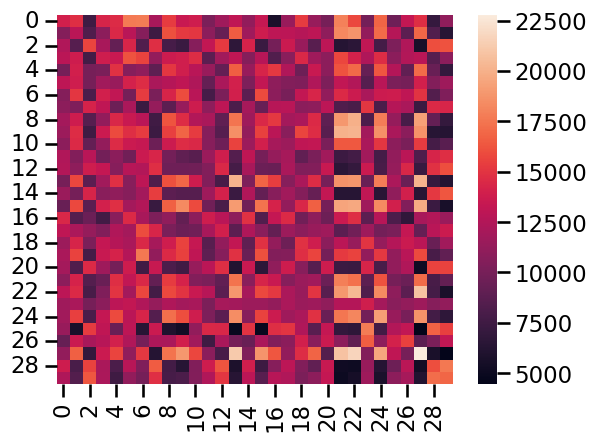

In [56]:
import seaborn as sns

sns.heatmap(dict_sum_condition["ctrl"][:30, :30])

In [28]:
groups = adata.obs.groupby("condition").groups

In [29]:
dict_sum_condition_mean = dict_sum_condition.copy()
for i in groups.keys():
    dict_sum_condition_mean[i] = dict_sum_condition_mean[i] / len(groups[i])
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [30]:
dict_sum_condition_mean

{'ctrl': array([[0.5742845 , 0.60792303, 0.30780593, ..., 0.86863446, 0.6319525 ,
         0.671541  ],
        [0.4349565 , 0.53109413, 0.33978382, ..., 0.510443  , 0.5792089 ,
         0.42998752],
        [0.51246315, 0.3517012 , 0.6440646 , ..., 0.3813701 , 0.25988093,
         0.4313632 ],
        ...,
        [0.47763273, 0.68226314, 0.46070477, ..., 0.7569421 , 0.6238084 ,
         0.53830934],
        [0.45896682, 0.7672031 , 0.37464306, ..., 0.6432361 , 0.87845457,
         0.61930716],
        [0.5318667 , 0.57676363, 0.4292396 , ..., 0.66398114, 0.6460707 ,
         0.6216081 ]], dtype=float32),
 'BHLHE40+ctrl': array([[0.5966292 , 0.5836896 , 0.30814475, ..., 0.8411932 , 0.6735841 ,
         0.6338797 ],
        [0.43540767, 0.5149689 , 0.36173704, ..., 0.43393648, 0.5066317 ,
         0.30853242],
        [0.4432934 , 0.26720023, 0.6600021 , ..., 0.3994989 , 0.27260542,
         0.47801462],
        ...,
        [0.47633383, 0.7150868 , 0.51553714, ..., 0.7688235 , 0.64500

In [18]:
dict_sum_condition_mean

{'ctrl': array([[0.7667165 , 0.5071312 , 0.363181  , ..., 0.6558552 , 0.6433118 ,
         0.5029277 ],
        [0.35063276, 0.90670127, 0.32875505, ..., 0.67563516, 0.4646933 ,
         0.4744476 ],
        [0.5349599 , 0.30492574, 0.63999563, ..., 0.37222496, 0.45482123,
         0.4780819 ],
        ...,
        [0.5522125 , 0.72981244, 0.347227  , ..., 0.7278823 , 0.5751889 ,
         0.48467204],
        [0.5728605 , 0.54362035, 0.49283794, ..., 0.5536558 , 0.71726304,
         0.59353757],
        [0.646479  , 0.52209556, 0.410678  , ..., 0.5902157 , 0.6444179 ,
         0.54989314]], dtype=float32),
 'BHLHE40+ctrl': array([[0.6798215 , 0.43131036, 0.39218244, ..., 0.67530143, 0.6967861 ,
         0.5009627 ],
        [0.28934428, 0.809951  , 0.30970335, ..., 0.61639196, 0.26737106,
         0.2312922 ],
        [0.5355754 , 0.28648922, 0.6779555 , ..., 0.3633715 , 0.51926744,
         0.59302956],
        ...,
        [0.5082808 , 0.69850725, 0.34680215, ..., 0.75059116, 0.61094

In [ ]:
        # Rank normalization by row
        attn_scores = attn_scores.reshape((-1, M))
        order = torch.argsort(attn_scores, dim=1)
        rank = torch.argsort(order, dim=1)
        attn_scores = rank.reshape((-1, 8, M, M)) / M
        # Rank normalization by column
        attn_scores = attn_scores.permute(0, 1, 3, 2).reshape((-1, M))
        order = torch.argsort(attn_scores, dim=1)
        rank = torch.argsort(order, dim=1)
        attn_scores = (rank.reshape((-1, 8, M, M)) / M).permute(0, 1, 3, 2)
        # Average 8 attention heads
        attn_scores = attn_scores.mean(1)

        outputs = attn_scores.detach().cpu().numpy()

        for index in range(batch_size):
            # Keep track of sum per condition
            c = condition_ids[i : i + batch_size][index]
            if c not in dict_sum_condition:
                dict_sum_condition[c] = np.zeros((M, M), dtype=np.float32)
            else:
                dict_sum_condition[c] += outputs[index, :, :]

## Step 3: Perform most influenced gene selection


In the manuscript, we proposed 3 settings for the most influenced gene
selection, namely _Control_, _Perturb_, and _Difference_. In this example, we
focus on the _Difference_ setting to explore how the gene-gene network changes
after perturbation compared to control.


In [31]:
def get_topk_most_influenced_genes(topk, setting):
    attn_top_gene_dict = {}
    attn_top_scores_dict = {}
    for i in groups.keys():
        if i != "ctrl":
            knockout_gene = i.split("+")[0]
            knockout_gene_idx = np.where(gene_vocab_idx == vocab([knockout_gene])[0])[
                0
            ][0]
            control = dict_sum_condition_mean["ctrl"][:, knockout_gene_idx]
            exp = dict_sum_condition_mean[i][:, knockout_gene_idx]
            # Chnage this line to exp, control, exp-control for three different settings
            if setting == "difference":
                a = exp - control
            elif setting == "control":
                a = control
            elif setting == "experiment":
                a = exp
            diff_idx = np.argpartition(a, -topk)[-topk:]
            scores = (a)[diff_idx]
            attn_top_genes = vocab.lookup_tokens(gene_vocab_idx[diff_idx]) + [TF_name]
            attn_top_gene_dict[i] = list(attn_top_genes)
            attn_top_scores_dict[i] = list(scores)
    return attn_top_gene_dict, attn_top_scores_dict

In [32]:
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [33]:
# Specify top k number of genes to be selected, and the selection setting
# Here calculate top 20 most influenced genes for CHIP-Atlas validation
topk = 20
setting = "difference"  # "control", "perturbed"
assert setting in ["difference", "control", "perturbed"]
attn_top_gene_dict_20, attn_top_scores_dict_20 = get_topk_most_influenced_genes(
    topk, setting
)
print(attn_top_scores_dict_20[TF_name + "+ctrl"])
print(attn_top_gene_dict_20[TF_name + "+ctrl"])

[0.17974377, 0.18082798, 0.18216205, 0.18462348, 0.19178969, 0.19324607, 0.19461662, 0.1971811, 0.1953389, 0.19469512, 0.19753253, 0.19573992, 0.19778228, 0.20109445, 0.21695876, 0.22958243, 0.20796436, 0.20723146, 0.20903969, 0.20859265]
['MYL4', 'PTTG1', 'SRRM2', 'SSR2', 'RTN4', 'CCDC85B', 'FUS', 'GYPA', 'PARP1', 'DBI', 'PSMD4', 'DNAJA1', 'EXOSC8', 'SFPQ', 'HNRNPD', 'HSPA8', 'TMBIM6', 'SH3BGRL3', 'UQCRB', 'GYPB', 'BHLHE40']


<Figure size 1800x1800 with 0 Axes>

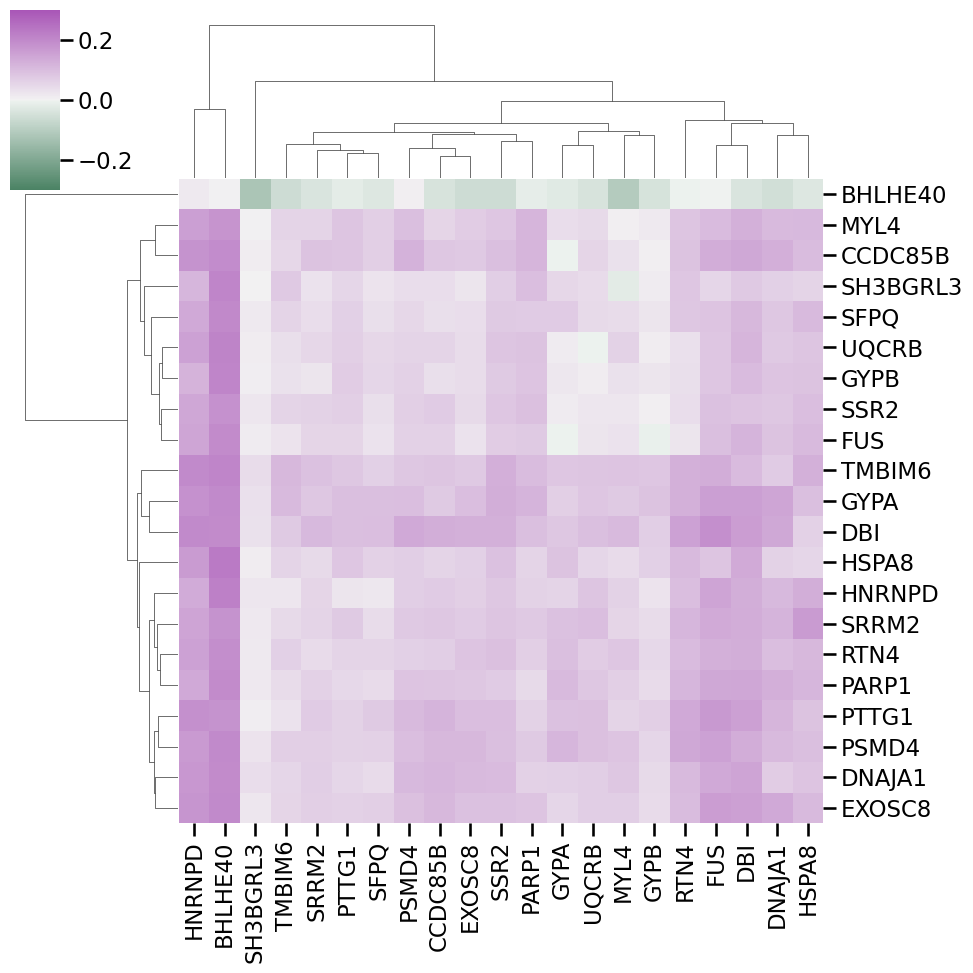

In [34]:
if setting == "difference":
    for i in attn_top_gene_dict_20.keys():
        example_genes = attn_top_gene_dict_20[i]
        gene_idx = [
            np.where(gene_vocab_idx == vocab([g])[0])[0][0] for g in example_genes
        ]
        scores = (
            dict_sum_condition_mean[i][gene_idx, :][:, gene_idx]
            - dict_sum_condition_mean["ctrl"][gene_idx, :][:, gene_idx]
        )
        df_scores = pd.DataFrame(
            data=scores, columns=example_genes, index=example_genes
        )
        plt.figure(figsize=(6, 6), dpi=300)
        ax = sns.clustermap(
            df_scores,
            annot=False,
            cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
            fmt=".2f",
            vmin=-0.3,
            vmax=0.3,
        )
        plt.show()
        plt.close()

<Figure size 1800x1800 with 0 Axes>

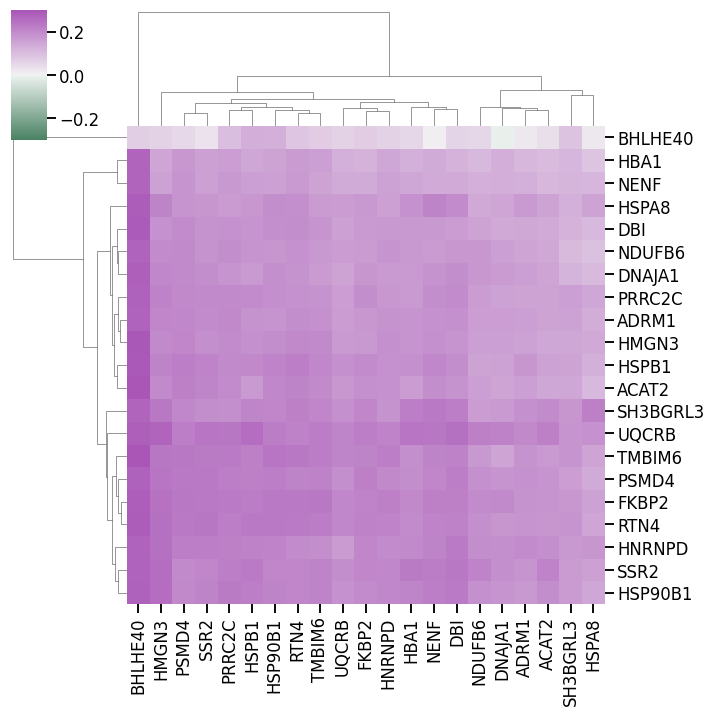

In [23]:
if setting == "difference":
    for i in attn_top_gene_dict_20.keys():
        example_genes = attn_top_gene_dict_20[i]
        gene_idx = [
            np.where(gene_vocab_idx == vocab([g])[0])[0][0] for g in example_genes
        ]
        scores = (
            dict_sum_condition_mean[i][gene_idx, :][:, gene_idx]
            - dict_sum_condition_mean["ctrl"][gene_idx, :][:, gene_idx]
        )
        df_scores = pd.DataFrame(
            data=scores, columns=example_genes, index=example_genes
        )
        plt.figure(figsize=(6, 6), dpi=300)
        ax = sns.clustermap(
            df_scores,
            annot=False,
            cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
            fmt=".2f",
            vmin=-0.3,
            vmax=0.3,
        )
        plt.show()
        plt.close()

In [35]:
# Specify top k number of genes to be selected, and the selection setting
# # Here calculate top 100 most influenced genes for pathway validation
topk = 100
setting = "difference"  # "control", "perturbed"
assert setting in ["difference", "control", "perturbed"]
attn_top_gene_dict_100, attn_top_scores_dict_100 = get_topk_most_influenced_genes(
    topk, setting
)
print(attn_top_scores_dict_100[TF_name + "+ctrl"])
print(attn_top_gene_dict_100[TF_name + "+ctrl"])

[0.0752303, 0.20859265, 0.16295224, 0.1971811, 0.11316484, 0.18462348, 0.09724718, 0.158782, 0.09412712, 0.16063309, 0.22958243, 0.17112052, 0.08037984, 0.14169514, 0.17872679, 0.090473026, 0.19324607, 0.14448231, 0.09751749, 0.0880225, 0.1201272, 0.17594087, 0.13083702, 0.106511205, 0.17096329, 0.080174506, 0.07891601, 0.20109445, 0.07867223, 0.07772222, 0.12440163, 0.17974377, 0.15514088, 0.14062035, 0.19178969, 0.13302839, 0.20723146, 0.20796436, 0.07658398, 0.07616922, 0.19778228, 0.1318911, 0.11101669, 0.08272201, 0.15474302, 0.08708018, 0.12751365, 0.12720191, 0.08016437, 0.076271415, 0.14067346, 0.1760832, 0.09925455, 0.07620722, 0.17684132, 0.19573992, 0.1570139, 0.15322667, 0.084185004, 0.087951064, 0.080433846, 0.12674385, 0.08444178, 0.08111143, 0.092929244, 0.111475885, 0.21695876, 0.19753253, 0.19461662, 0.10788423, 0.17590642, 0.096800864, 0.102776945, 0.10742286, 0.1235905, 0.10832739, 0.09279007, 0.16145891, 0.17972463, 0.08507359, 0.15073979, 0.19469512, 0.20903969, 0.

In [24]:
# Specify top k number of genes to be selected, and the selection setting
# # Here calculate top 100 most influenced genes for pathway validation
topk = 100
setting = "difference"  # "control", "perturbed"
assert setting in ["difference", "control", "perturbed"]
attn_top_gene_dict_100, attn_top_scores_dict_100 = get_topk_most_influenced_genes(
    topk, setting
)
print(attn_top_scores_dict_100[TF_name + "+ctrl"])
print(attn_top_gene_dict_100[TF_name + "+ctrl"])

[0.13435426, 0.13445804, 0.13521338, 0.13658851, 0.13494265, 0.1378941, 0.25253183, 0.27598792, 0.27320516, 0.19422996, 0.1749267, 0.14947963, 0.28356528, 0.19787788, 0.21807176, 0.27211004, 0.19592029, 0.192339, 0.26201934, 0.27022785, 0.18904561, 0.2630661, 0.17665666, 0.25517708, 0.1592493, 0.28411555, 0.15643954, 0.17658818, 0.28957933, 0.23216242, 0.27515042, 0.17963398, 0.17776287, 0.21403193, 0.1494323, 0.26097095, 0.2147252, 0.2868172, 0.1864397, 0.19282275, 0.17112768, 0.18815774, 0.19837373, 0.14006501, 0.15750575, 0.22382861, 0.2719887, 0.25040454, 0.25988054, 0.26159328, 0.14806324, 0.20562506, 0.26052994, 0.20960271, 0.17409635, 0.22525501, 0.26490605, 0.20550716, 0.15476418, 0.14542323, 0.30242187, 0.16769892, 0.1891504, 0.16443193, 0.2682315, 0.25884175, 0.25024498, 0.26073533, 0.15007758, 0.27020293, 0.27914363, 0.24032599, 0.16723317, 0.18915558, 0.27392942, 0.15589827, 0.1956358, 0.15076661, 0.14257717, 0.2255286, 0.18222451, 0.2942825, 0.18665028, 0.29776084, 0.29275

## Step 4: Validate most influenced genes


### Step 4.1: Validate against CHIP-Atlas


First load the tsv file from CHIP-Atlas containing targets of BHLHE40. The tsv
file for BHLHE40 can be downloaded via this
[link](https://drive.google.com/drive/folders/1nc1LywRHlzt4Z17McfXiqBWgoGbRNyc0).
This tsv file was originally retrieved from the
[CHIP-Atlas](https://chip-atlas.org/target_genes) website.


In [38]:
ls ../../GroundTruth/

hESC_Chen_Genes.tsv    hESC_Liu_TFs.tsv       mESC_Semrau_Genes.tsv
hESC_Chen_TFs.tsv      mESC_Duren_Genes.tsv   mESC_Semrau_TFs.tsv
hESC_ground_truth.tsv  mESC_Duren_TFs.tsv     scRNA/
hESC_Liu_Genes.tsv     mESC_ground_truth.tsv


In [39]:
df = pd.read_csv("../BHLHE40.10.tsv", delimiter="\t")

Examine the overalp between the selected genes (top 20) and known target genes
from the database.


In [40]:
df

,Target_genes,BHLHE40|Average,SRX2424487|293,SRX2424488|293,SRX150519|A549,SRX150509|GM12878,SRX3322985|GM12878,SRX3322986|GM12878,SRX6888831|HeLa,SRX6888832|HeLa,...,SRX15783136|Jurkat,SRX15783137|Jurkat,SRX15783138|Jurkat,SRX19471788|Jurkat,SRX19471789|Jurkat,SRX19471796|Jurkat,SRX19471797|Jurkat,SRX150695|K-562,SRX359985|LoVo,STRING
0,CLUAP1,1414.708333,844,509,1872,2298,3403,3625,949,622,...,0,0,0,1165,1715,3056,2561,2191,0,0
1,C16orf90,1414.708333,844,509,1872,2298,3403,3625,949,622,...,0,0,0,1165,1715,3056,2561,2191,0,0
2,CCDC86,1354.458333,444,201,1644,2380,3504,3539,704,309,...,0,0,0,1383,2292,3371,2902,1931,0,0
3,SCAP,1327.750000,595,233,1714,2338,3210,3449,1522,817,...,0,0,0,985,1338,2719,2489,1753,0,0
4,SNRPE,1308.625000,373,171,1578,2476,3674,3623,505,310,...,0,0,0,1237,1797,3109,2728,1969,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15800,C3orf49,2.875000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15801,PRSS35,2.833333,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,68,0,0
15802,FAM71E2,2.625000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,63,0,0
15803,COX6B2,2.625000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,63,0,0


In [50]:
len(set(gene_list).intersection(set(df[df["BHLHE40|Average"] > 600]["Target_genes"])))

1

In [41]:
gene_list = attn_top_gene_dict_20[TF_name + "+ctrl"][:-1]
set(gene_list).intersection(set(df["Target_genes"].values)), len(
    set(gene_list).intersection(set(df["Target_genes"].values))
)

({'CCDC85B',
  'DBI',
  'DNAJA1',
  'EXOSC8',
  'FUS',
  'GYPA',
  'GYPB',
  'HNRNPD',
  'HSPA8',
  'MYL4',
  'PARP1',
  'PSMD4',
  'PTTG1',
  'RTN4',
  'SFPQ',
  'SH3BGRL3',
  'SRRM2',
  'SSR2',
  'TMBIM6',
  'UQCRB'},
 20)

In [26]:
gene_list = attn_top_gene_dict_20[TF_name + "+ctrl"][:-1]
set(gene_list).intersection(set(df["Target_genes"].values)), len(
    set(gene_list).intersection(set(df["Target_genes"].values))
)

({'ACAT2',
  'ADRM1',
  'DBI',
  'DNAJA1',
  'FKBP2',
  'HBA1',
  'HMGN3',
  'HNRNPD',
  'HSP90B1',
  'HSPA8',
  'HSPB1',
  'NDUFB6',
  'PRRC2C',
  'PSMD4',
  'RTN4',
  'SH3BGRL3',
  'SSR2',
  'TMBIM6',
  'UQCRB'},
 19)

Visualize the network and strength of the edges (annotated with rank-normalized
attention scores).


In [42]:
score_list = attn_top_scores_dict_20[TF_name + "+ctrl"]

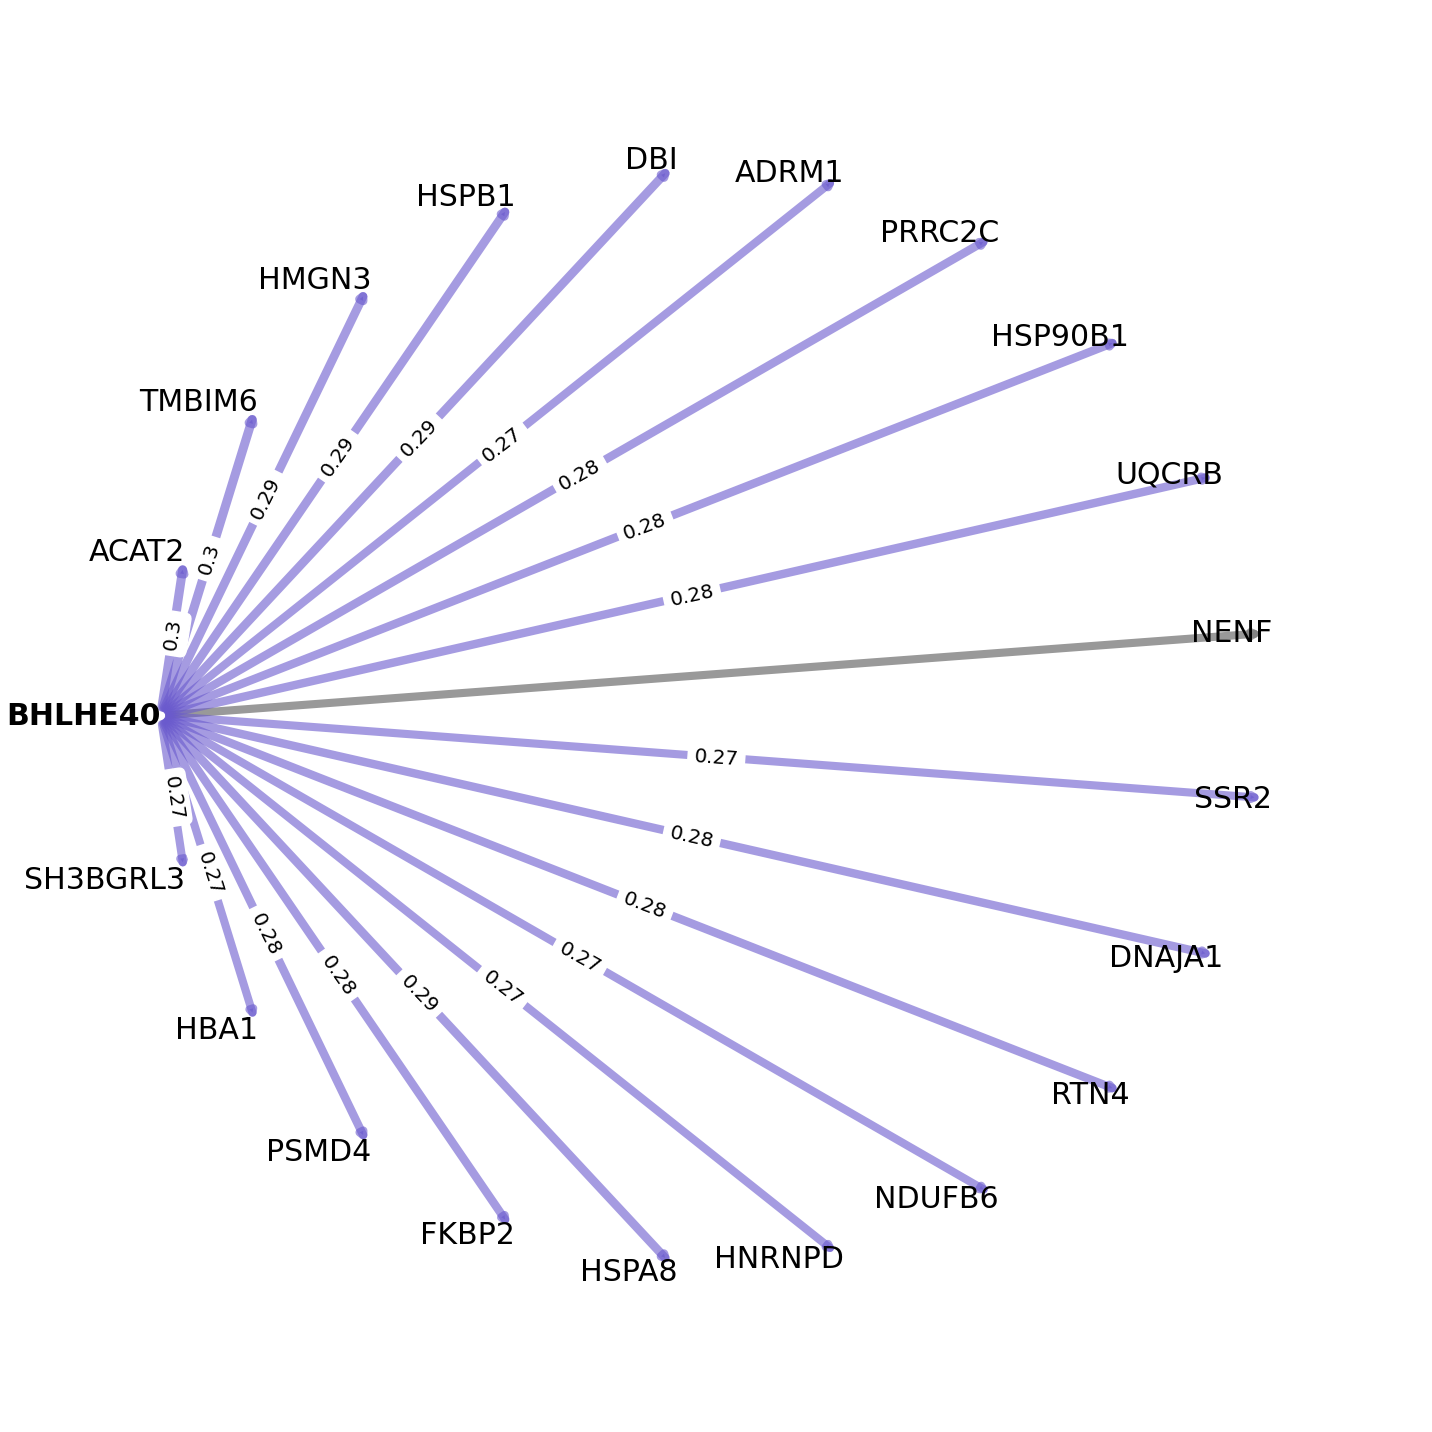

In [28]:
hits = set(gene_list).intersection(set(df["Target_genes"].values))

G = nx.DiGraph()
edge_list = [
    (TF_name, gene_list[i], round(score_list[i], 2)) for i in range(len(gene_list))
]
G.add_weighted_edges_from(edge_list)

plt.figure(figsize=(20, 20))
edges = list(G.edges)
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if v in hits]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if v not in hits]
pos = nx.shell_layout(G)
width_large = {}
width_small = {}
for i, v in enumerate(edges):
    if v[1] in hits:
        width_large[edges[i]] = G.get_edge_data(v[0], v[1])["weight"] * 30
    else:
        width_small[edges[i]] = max(G.get_edge_data(v[0], v[1])["weight"], 0) * 30
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=width_small.keys(),
    width=list(width_small.values()),
    edge_color="grey",
    alpha=0.8,
)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=width_large.keys(),
    width=list(width_large.values()),
    alpha=0.6,
    edge_color="slateblue",
)
labels = {}
for i in pos.keys():
    if i == TF_name:
        labels[i] = ""
    else:
        labels[i] = i

labels1 = {}
for i in pos.keys():
    if i != TF_name:
        labels1[i] = ""
    else:
        labels1[i] = i
nx.draw_networkx_labels(
    G, pos, labels, font_size=30, font_family="sans-serif", horizontalalignment="right"
)
nx.draw_networkx_labels(
    G,
    pos,
    labels1,
    font_size=30,
    font_family="sans-serif",
    font_weight="bold",
    horizontalalignment="right",
)

d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=20)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

### Step 4.2: Validate against the Reactome database


We perform pathway analysis on the top 100 most influenced genes by checking
against the Reactome database. This replicates the reported pathways found in
the _Difference_ setting in the manuscript for the select TF.


In [29]:
# Validate with Reactome
df_database = pd.DataFrame(
    data=[
        ["GO_Biological_Process_2021", 6036],
        ["GO_Molecular_Function_2021", 1274],
        ["Reactome_2022", 1818],
    ],
    columns=["dataset", "term"],
)

In [30]:
databases = ["Reactome_2022"]
m = df_database[df_database["dataset"].isin(databases)][
    "term"
].sum()  # df_database['term'].sum()
p_thresh = 0.05 / ((len(groups.keys()) - 1) * m)

In [31]:
gene_list = attn_top_gene_dict_100[TF_name + "+ctrl"]

In [32]:
df_attn = pd.DataFrame()
enr_Reactome = gp.enrichr(
    gene_list=gene_list,
    gene_sets=databases,
    organism="Human",
    outdir="test",
    cutoff=0.5,
)
out = enr_Reactome.results
out["Gene List"] = str(gene_list)
out = out[out["P-value"] < p_thresh]
df_attn = df_attn.append(out, ignore_index=True)

In [33]:
len(df_attn)

6

In [34]:
df_attn

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene List
0,Reactome_2022,AUF1 (hnRNP D0) Binds And Destabilizes mRNA R-...,6/54,3.029798e-07,0.000087,0,0,26.119737,392.046796,HSPA8;PSMD12;PSMD4;UBC;HNRNPD;HSPB1,"['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC..."
1,Reactome_2022,Regulation Of mRNA Stability By Proteins That ...,7/88,3.082629e-07,0.000087,0,0,18.219858,273.157814,HSPA8;PSMD12;PSMD4;EXOSC8;UBC;HNRNPD;HSPB1,"['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC..."
2,Reactome_2022,Cellular Responses To Stress R-HSA-2262752,16/722,6.458517e-07,0.000117,0,0,5.117280,72.935042,HSPA8;PSMD12;HSPA5;CITED2;HBA1;HSP90B1;EEF1A1;...,"['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC..."
3,Reactome_2022,Cellular Responses To Stimuli R-HSA-8953897,16/736,8.318572e-07,0.000117,0,0,5.014118,70.195667,HSPA8;PSMD12;HSPA5;CITED2;HBA1;HSP90B1;EEF1A1;...,"['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC..."
4,Reactome_2022,S Phase R-HSA-69242,7/161,1.753446e-05,0.001971,0,0,9.547872,104.562021,PSMD12;PCNA;PSMD4;UBE2S;MYC;UBC;MCM3,"['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC..."
5,Reactome_2022,APC/C:Cdc20 Mediated Degradation Of Securin R-...,5/67,2.239572e-05,0.002098,0,0,16.664147,178.417027,PSMD12;PSMD4;PTTG1;UBE2S;UBC,"['IL1RN', 'ARHGDIB', 'COL2A1', 'TRAPPC6A', 'PC..."
